## Wan Yi Lam (S4060745)

In [2]:
import networkx as nx
import json
import matplotlib.pyplot as plt

# Reply Graph - Reddit - Maleficent

In [3]:
sFileName = 'reddit_maleficent_reply_graph.graphml'

# Initialize the directed graph
replyGraph = nx.DiGraph()

# Initialize dictionary to map full IDs to authors for submissions
dSubCommentId = {}

In [5]:
input_json_file = 'reddit_posts_maleficent_processed.json' 
with open(input_json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

def flatten_comments(comments_list, parent_id):
    """
    Recursively flattens hierarchical comments.
    
    @param  comments_list: A list of comment dictionaries.
    @param  parent_id: The full ID of the parent item (submission or another comment).
    Returns:
        list: A flat list of dictionaries, each representing a comment/reply
              with its full_id, author, and parent_id.
    """
    result = []
    # Ensure comments_list is actually a list; if it's None or not present, treat as empty
    for comment in comments_list if comments_list else []:
        comment_id = comment.get("id")
        author = comment.get("author", "UnknownAuthor") # Handle missing author

        if not comment_id:
            continue # Skip if comment has no ID

        full_id = "t1_" + str(comment_id) # Reddit comment prefix
        result.append({"full_id": full_id, "author": author, "parent_id": parent_id})
        
        # Recursively process replies for this comment
        replies_data = comment.get("replies", [])
        if replies_data: # Check if there are any replies to process
            result.extend(flatten_comments(replies_data, full_id))
    return result

def process_post(post_data):
    """
    Processes a single post dictionary, building the reply graph and ID mappings.
    """
    try:
        submission_id = post_data.get('id')
        author = post_data.get('author', 'UnknownAuthor') # Handle missing 'author'

        if not submission_id:
            print(f"Warning: Submission missing 'id', skipping: {post_data.get('title', 'No Title')}")
            return

        submission_full_id = "t3_" + str(submission_id) # Reddit submission prefix

        # Add/update the submission author in the graph
        if author in replyGraph:
            replyGraph.nodes[author]['subNum'] = replyGraph.nodes[author].get('subNum', 0) + 1
        else:
            replyGraph.add_node(author, subNum=1) 

        # Initialize the ID-to-author mapping for this submission
        if submission_full_id not in dSubCommentId:
             dSubCommentId[submission_full_id] = {}
        dSubCommentId[submission_full_id][submission_full_id] = author

        # Get top-level comments for the post, defaulting to an empty list if 'comments' key is missing
        top_level_comments = post_data.get("comments", [])
        flat_comments = flatten_comments(top_level_comments, submission_full_id)

        # Add all comments to the ID-to-author mapping for this submission
        for comment_info in flat_comments:
            dSubCommentId[submission_full_id][comment_info["full_id"]] = comment_info["author"]

        # Construct the reply graph by adding edges
        for comment_info in flat_comments:
            comment_author = comment_info["author"]
            parent_item_full_id = comment_info["parent_id"]

            # Ensure current comment_author node exists (might be new if they only replied)
            if comment_author not in replyGraph:
                replyGraph.add_node(comment_author, subNum=0) # subNum 0 if they haven't submitted

            if parent_item_full_id in dSubCommentId[submission_full_id]:
                parent_author = dSubCommentId[submission_full_id][parent_item_full_id]
                
                # Ensure parent_author node exists (should generally, but good practice)
                if parent_author not in replyGraph:
                    replyGraph.add_node(parent_author, subNum=0) # Default subNum if somehow missed

                # Add or update the directed edge: comment_author -> parent_author
                if replyGraph.has_edge(comment_author, parent_author):
                    replyGraph[comment_author][parent_author]['replyNum'] += 1
                else:
                    replyGraph.add_edge(comment_author, parent_author, replyNum=1)

    except Exception as e: # Catching general exception for broader error reporting during processing a post
        print(f"Error processing post (ID: {post_data.get('id', 'N/A')}): {e}")

# Main Processing
with open(input_json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

# Handle different JSON structures based on the top-level key
if 'submissions' in data:
    submissions_list = data['submissions']
    if isinstance(submissions_list, list):
        print(f"Found {len(submissions_list)} submissions to process.")
        for i, post_item in enumerate(submissions_list):
            if isinstance(post_item, dict):
                process_post(post_item)
            else:
                print(f"Warning: Item in 'submissions' list is not a dictionary: {type(post_item)}")
    elif isinstance(submissions_list, dict): # If "submissions" key holds a single post object
        print("Found a single submission object under 'submissions' key.")
        process_post(submissions_list)
    else:
        print(f"Error: Unexpected type for 'submissions': {type(submissions_list)}")
elif isinstance(data, list): # If the JSON root is directly a list of posts
    print(f"Found a list of {len(data)} posts at the JSON root.")
    for i, post_item in enumerate(data):
        if isinstance(post_item, dict):
            process_post(post_item)
        else:
            print(f"Warning: Item in root list is not a dictionary: {type(post_item)}")
elif isinstance(data, dict): 
    print("Found a single post object at the JSON root.")
    process_post(data)
else:
    print(f"Error: Unrecognized JSON structure. Expected 'submissions' key or a list/dict of posts at root. Got: {type(data)}")

# Print the nodes
print(replyGraph.nodes)

# Save the graph to a file
nx.readwrite.write_graphml(replyGraph, sFileName)

Found 39 submissions to process.
['Bennett1984', 'gmessad', 'gborder79', 'nathlong', 'HeartyBeast', 'make_love_to_potato', 'BroskiMcDoogleheimer', 'metro99', 'iamtherik', 'missed_againn', 'unwanted_puppy', 'McIgglyTuffMuffin', 'utspg1980', 'serasirena', 'nikils', 'SoupOfTomato', 'InflatableTomato', 'Simify', 'tinfang', 'familiar_face', 'ReyRey5280', 'chowder138', '2littlesnugglebugs', 'brasco975', 'phd_professor', 'hatramroany', 'dantemirror', 'stickychopchops', 'sirin3', 'Karl_Satan', 'eye_fork', 'Kadexe', 'GodofIrony', 'stormcynk', 'happycatface', 'pieface42', 'DarkGenex', 'feihtality', 'LordOfCows', 'venegal', 'stamatt45', 'snorbaard', 'raknor88', 'Talvoren', 'imSHELLSHOCKED', 'oSolar', 'AliveProbably', 'aeschenkarnos', 'citrus_based_arson', 'FOPTIMUS_PRIM', 'LibertarianSocialism', 'leafofpennyroyal', 'Faithless195', 'craiger8719', 'Sekular', 'arkain123', 'rolfraikou', 'DanWallace', 'FountainsOfFluids', 'guymannly', 'RellenD', 'Phoequinox', 'FirePowerCR', 'Crysalim', 'jrf_1973', 'ap

### Reference: Codes below are from COSC2671 Social Media and Network Analytics Workshop 8 & 9, created by Jeffrey Chan, RMIT University, 2023.

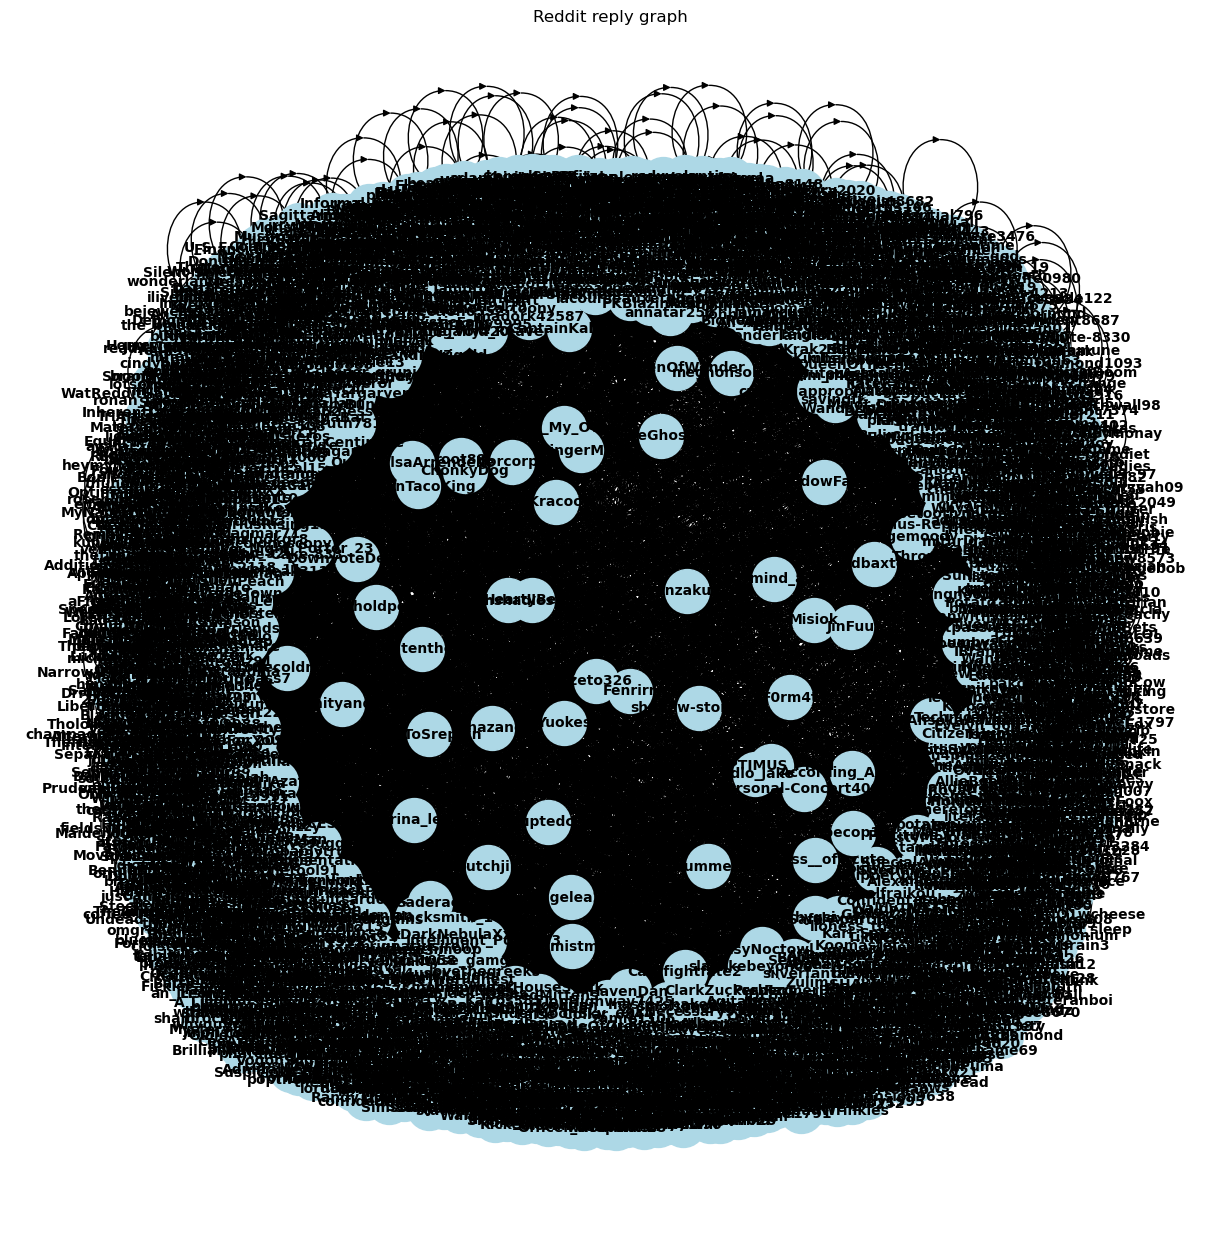

Number of nodes (authors): 2663
Number of edges (replies): 5970


In [6]:
nx.readwrite.write_graphml(replyGraph, sFileName)   
# read the graph from the file
replyGraph = nx.readwrite.read_graphml(sFileName)
# draw the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(replyGraph, k=0.5, iterations=20)
nx.draw(replyGraph, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
plt.title('Reddit reply graph')
plt.show()
# print the number of nodes and edges
print(f"Number of nodes (authors): {replyGraph.number_of_nodes()}")
print(f"Number of edges (replies): {replyGraph.number_of_edges()}")

# SNA Measures - Reddit - Maleficent

In [7]:

sFileName = 'reddit_maleficent_reply_graph.graphml'

# read it back in to demonstrate it works
replyGraph = nx.readwrite.read_graphml(sFileName)


# Degree centrality 
lDegCentrality = nx.degree_centrality(replyGraph)


# eigenvetor and katz centrality
lEigenVectorCentrality = nx.eigenvector_centrality(replyGraph)

# Katz centrality
# Compute the largest eigenvalue of the adjacency matrix
lambda_max = max(nx.adjacency_spectrum(replyGraph)) # Returns max eigenvalues 
print("Largest eigenvalue (λ_max):", lambda_max)

# Set the optimal alpha to a value slightly less than 1 / lambda_max
alpha = 1 / lambda_max - 0.01
print("Optimal alpha:", alpha)

# Compute Katz centrality with the adjusted alpha
lKatzCentrality = nx.katz_centrality(replyGraph, alpha=alpha)


print("Degree Centrality: ", lDegCentrality)
print("Eigenvector Centrality: ", lEigenVectorCentrality)
print("Katz Centrality: ", lKatzCentrality)


Largest eigenvalue (λ_max): (6.743717449150212+0j)
Optimal alpha: (0.13828616524051016+0j)
Degree Centrality:  {'Bennett1984': 0.10969196093163036, 'gmessad': 0.010518407212622089, 'gborder79': 0.007888805409466567, 'nathlong': 0.004507888805409466, 'HeartyBeast': 0.006010518407212622, 'make_love_to_potato': 0.0037565740045078892, 'BroskiMcDoogleheimer': 0.0018782870022539446, 'metro99': 0.0018782870022539446, 'iamtherik': 0.0018782870022539446, 'missed_againn': 0.0018782870022539446, 'unwanted_puppy': 0.002253944402704733, 'McIgglyTuffMuffin': 0.002253944402704733, 'utspg1980': 0.0018782870022539446, 'serasirena': 0.0011269722013523666, 'nikils': 0.0011269722013523666, 'SoupOfTomato': 0.0015026296018031556, 'InflatableTomato': 0.0015026296018031556, 'Simify': 0.0018782870022539446, 'tinfang': 0.0067618332081142, 'familiar_face': 0.0011269722013523666, 'ReyRey5280': 0.0011269722013523666, 'chowder138': 0.0011269722013523666, '2littlesnugglebugs': 0.0011269722013523666, 'brasco975': 0.0

/opt/anaconda3/lib/python3.12/site-packages/networkx/algorithms/centrality/katz.py:185: ComplexWarning: Casting complex values to real discards the imaginary part
  s = 1.0 / math.hypot(*x.values())


/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/histograms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6865: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


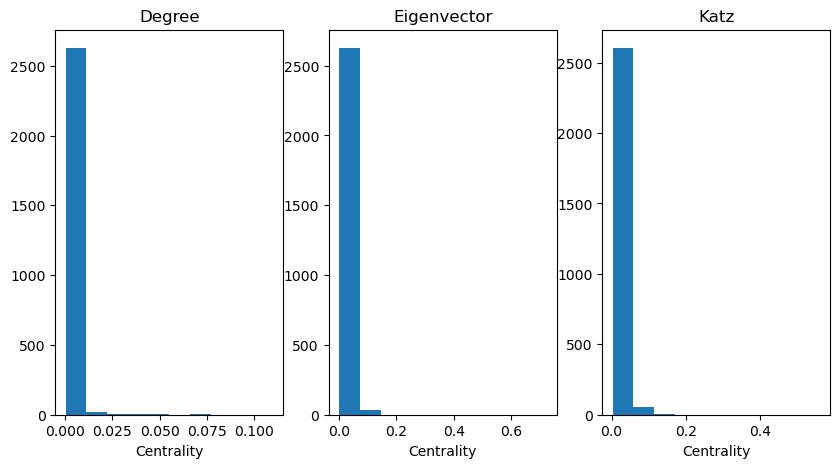

In [8]:
# plot histograms
plt.figure(figsize=(10, 5))
# Degree centrality
plt.subplot(1,3,1)
plt.hist(list(lDegCentrality.values()))
plt.title('Degree')
plt.xlabel('Centrality')
# eigenvector centrality
plt.subplot(1, 3, 2)
plt.hist(list(lEigenVectorCentrality.values()))
plt.title('Eigenvector')
plt.xlabel('Centrality')
# katz centrality
plt.subplot(1, 3, 3)
plt.hist(list(lKatzCentrality.values()))
plt.title('Katz')
plt.xlabel('Centrality')
plt.show()


In [9]:
#
# TODO: update the node attributes with centrality
#
# eigenvector centrality, stored in node attribute 'eigen'
for nodeId, cent in lEigenVectorCentrality.items():
    replyGraph.nodes[nodeId]['eigen'] = float(cent)

# katz centrality, stored in node attribute 'katz'
for nodeId, cent in lKatzCentrality.items():
    replyGraph.nodes[nodeId]['katz'] = float(cent)


#
# TODO: write out graph to new file
#
nx.readwrite.write_graphml(replyGraph, 'mod' + sFileName, infer_numeric_types=True)


#
# TODO: compute the other SNA measures specified in the lab
#

#
# compute clustering
# the networkx code is within format(...)
#
print('Gloabl clustering coefficient/transitivity = {}'.format(nx.transitivity(replyGraph)))


#
# compute components
#
print('number of strongly connected components = {}'.format(nx.number_strongly_connected_components(replyGraph)))
print('number of weakly connected components = {}'.format(nx.number_weakly_connected_components(replyGraph)))

#
# compute bridges
#
print(list(nx.bridges(replyGraph.to_undirected())))

/var/folders/jv/6r6lx6cn5cs2bvq_5zljg07r0000gn/T/ipykernel_88489/3352379202.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  replyGraph.nodes[nodeId]['katz'] = float(cent)


Gloabl clustering coefficient/transitivity = 0.3344988344988345
number of strongly connected components = 2215
number of weakly connected components = 3
[('Bennett1984', 'chefmcduck'), ('Bennett1984', 'meghonsolozar'), ('Bennett1984', 'dvd_00'), ('Bennett1984', 'majoun'), ('Bennett1984', 'thedieversion'), ('Bennett1984', 'cellur111'), ('Bennett1984', 'HavenDan'), ('Bennett1984', 'armyofpun'), ('Bennett1984', 'Guild_Navigator'), ('Bennett1984', 'spikus93'), ('Bennett1984', 'synan'), ('Bennett1984', 'Brisk_Driver'), ('Bennett1984', 'imusuallycorrect'), ('Bennett1984', 'ManateeofSteel'), ('Bennett1984', 'thedivineredapple'), ('Bennett1984', 'thatnobleguy'), ('Bennett1984', 'F_J_Underwood'), ('Bennett1984', 'LegatoSkyheart'), ('Bennett1984', 'AppleDane'), ('Bennett1984', 'Empyrealist'), ('Bennett1984', 'swag_dude69'), ('Bennett1984', 'codesign'), ('Bennett1984', 'kbuis'), ('Bennett1984', 'rikaateabug'), ('Bennett1984', 'cowgod42'), ('Bennett1984', 'adambuck66'), ('Bennett1984', 'lokijki'),

In [10]:
# filename of graph to read in
sFilename = "modreddit_maleficent_reply_graph.graphml"


In [11]:
def dictToSetFormat(dComms, maxCommNum):
    """
    Converts dictionary based community output (node -> community id) to list of sets (communities)
    @param dComms: dictionary based community representation
    @param maxCommNum: maximum number of communities
    @return: list of communities representation
    """

    # initialise
    com_list = [set() for x in range(maxCommNum)]
    # convert each (node : community id) pair to the required set format
    for (name, clusId) in dComms.items():
        com_list[clusId].add(name)

    return com_list

## Constructs communities

In [12]:
# read the reply graph in
from networkx.algorithms import community
import community as community_louvain

replyGraph = nx.readwrite.read_graphml(sFilename)

#
# compute communities
#

#
# TODO: Implement CPM
#

# k (clique size) 
k = 3 # minimum value of a smallest complete graph
# placeholder.  Add the implementation to the right, but maintain the variable name.
lCpmComms = list(nx.algorithms.community.k_clique_communities(nx.to_undirected(replyGraph), k))
print(lCpmComms) # Print out the output of the communities by using the CPM algorithm

#
# TODO: Implement louvain
# louvain
# Use the Louvain algorithm from the python-louvain package
dLouvainComms = community_louvain.best_partition(nx.to_undirected(replyGraph))
print(dLouvainComms) # Print out the output of the communities by using the Louvain algorithm

# this code converts output of Louvain to the same format as CPM (makes it easier to have one consistent interface
louvanCommNum = max([y for (x,y) in dLouvainComms.items()]) + 1
lLouvainComms = dictToSetFormat(dLouvainComms, louvanCommNum)


#
# TODO: Write out cpm and Louvain values to node attributes of graph
#

# cpm labels, stored in node attribute 'cpmClusId'
for clusId, lComms in enumerate(lCpmComms):
    for nodeId in lComms:
        replyGraph.nodes[nodeId]['cpmClusId'] = clusId

# louvain labels, stored in node attribute 'louvain'
for clusId, lComms in enumerate(lLouvainComms):
    for nodeId in lComms:
        replyGraph.nodes[nodeId]['louvain'] = clusId


# Output modified graph with prefix mod2 to original file.
nx.readwrite.write_graphml(replyGraph, 'mod2' + sFilename, infer_numeric_types=True)



[frozenset({'Wubbledaddy', 'bloodflart', 'Kairos385', 'GetToSreppin', 'TholomewPlague31', 'Ph886', 'yatcho', 'tombstoneshadows28', 'KrisKomet', 'leavemetodiehere', 'tunaman9000', 'theTunkMan', 'theguyfromuncle420', 'gettodaze'}), frozenset({'Lili_Danube', 'Warm-Enthusiasm-9534', 'Worthyness', 'HomeTurf001', 'JohnnyJayce', 'PhiloPhocion'}), frozenset({'act1989', 'ritabook84', 'caustacyst', 'calebfitz'}), frozenset({'Lili_Danube', 'halborn', 'Hoserposerbro', 'showerofshellfish', 'KCCham'}), frozenset({'GreenWeenie1965', 'OnlyAtJmart82', 'WatRedditHathWrought'}), frozenset({'Lili_Danube', 'corruptedcircle', 'chambergambit', 'cowdoyspitoon', 'Skyfryer', 'Night_Porter_23'}), frozenset({'Gearfree', 'MyThatsWit', 'AZSnakepit1', 'sanjuro_kurosawa', 'WorthPlease', 'odaeyss', 'phreek-hyperbole', 'Four_beastlings', 'PayaV87', 'AmenTensen', 'SuperDanOsborne', 'athiaxoff', 'pizzapiejaialai', 'SealedRoute'}), frozenset({'Alarming_Orchid', 'DeviousMrBlonde', 'areacode212', 'RindFisch', 'VogonSoup', '